In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import low_rank_models as lrm

/home/yuji/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('error_matrix_small.csv', index_col=0)
models = np.array(list(df))
dataset_IDs = df.index.values
errorMtx = df.values
n_datasets, n_models = errorMtx.shape

In [3]:
RANK = 9
LAMBDA = 10
MU = 10
GAMMA = 1
LEARNING_RATE = 0.01
N_EPOCHS = 10000

In [4]:
x = tf.placeholder(tf.float32, shape=[None, n_models], name='input')

reg1 = tf.constant(0.0)  # regularizer enforcing at most RANK weights are active
reg2 = tf.constant(0.0)  # regularizer enforcing weights are boolean
reg3 = tf.constant(0.0)  # regularizer enforcing each entry is selected at most once

with tf.variable_scope('encoder'):
    we = tf.get_variable('w', 
                        initializer=tf.constant(0.5*np.ones([n_models, RANK]), dtype=tf.float32),
                        constraint=lambda x: tf.clip_by_value(x, 0, 1))
    encoded = tf.matmul(x, we)
    reg1 += LAMBDA * tf.nn.l2_loss(tf.reduce_sum(we, axis=0) - tf.constant(np.ones(RANK), dtype=tf.float32))
    reg2 += MU * (1 - tf.nn.l2_loss(we - 0.5))
    reg3 += GAMMA * tf.nn.l2_loss(tf.reduce_sum(we, axis=1))

with tf.variable_scope('decoder_1'):
    wd1 = tf.get_variable('w', initializer=tf.truncated_normal([RANK, n_models]))
    bd1 = tf.get_variable('b', initializer=tf.zeros([n_models]))
    d1 = tf.matmul(encoded, wd1) + bd1
    
'''
with tf.variable_scope('decoder_2'):
    wd2 = tf.get_variable('w', initializer=tf.truncated_normal([n_models, n_models]))
    bd2 = tf.get_variable('b', initializer=tf.zeros([n_models]))
    d2 = tf.matmul(d1, wd2) + bd2
'''
    
loss = tf.nn.l2_loss(x - d1)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss + reg1 + reg2 + reg3)
init = tf.global_variables_initializer()

In [5]:
sess = tf.InteractiveSession()
sess.run(init)

for i in range(N_EPOCHS):
    sess.run(optimizer, feed_dict={x:errorMtx})
    if i%1000 == 999 or i==0:
        l,r1,r2 = sess.run([loss, reg1, reg2], feed_dict={x:errorMtx})
        print("epoch %6d, loss=%6f, regularizer1=%0.4f, regularizer2=%0.4f" % (i+1, l, round(r1, 4), round(r2, 4)))

epoch      1, loss=291375.500000, regularizer1=14758.7324, regularizer2=9.8245
epoch   1000, loss=26.676907, regularizer1=4.4745, regularizer2=-397.9978
epoch   2000, loss=17.890551, regularizer1=5.7950, regularizer2=-400.3880
epoch   3000, loss=13.608894, regularizer1=6.5021, regularizer2=-402.8827
epoch   4000, loss=12.411314, regularizer1=6.7519, regularizer2=-405.4857
epoch   5000, loss=13.153906, regularizer1=4.7234, regularizer2=-413.3744
epoch   6000, loss=13.735346, regularizer1=1.2030, regularizer2=-421.3280
epoch   7000, loss=13.328751, regularizer1=0.5930, regularizer2=-427.1447
epoch   8000, loss=11.977673, regularizer1=0.0113, regularizer2=-428.4497
epoch   9000, loss=10.394178, regularizer1=0.0000, regularizer2=-428.7500
epoch  10000, loss=9.647133, regularizer1=0.0000, regularizer2=-428.7500


In [6]:
w = np.array(sess.run([we]))[0]

In [7]:
np.sum(w, axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

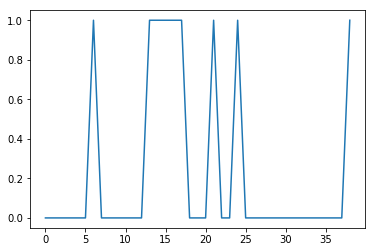

In [8]:
plt.plot(np.arange(39), np.sum(w, axis=1))
plt.show()

In [10]:
sampled_cols = np.argsort(-np.sum(w, axis=1))[:RANK]
sampled_cols

array([38, 24, 17, 16, 15, 14, 13, 21,  6])

In [19]:
bestModel = np.argmin(errorMtx, axis=1)
bestAlg = sameAlg(bestModel)
bestError = np.min(errorMtx, axis=1)
algtypes = np.sort(np.unique(bestAlg))

In [18]:
def sameAlg(testBestCol):
    testBestAlgType = []
    for i in range(len(testBestCol)):
        # testBestAlgType.append(eval(models[testBestCol[i]])['algorithm'])
        testBestAlgType.append(models[testBestCol[i]].split('.')[0])
    return np.array(testBestAlgType)

In [16]:
predicted = ()
for i in range(n_datasets):
    a = errorMtx[i].reshape(1,-1)
    A = np.delete(errorMtx, i, axis=0)
    a_hat = np.zeros((1, n_models))
    X,Y,Vt = lrm.pca(A, rank=RANK)
    a_hat[:,sampled_cols] = a[:,sampled_cols]
    a_hat = lrm.low_rank_approximation(A, a_hat, sampled_cols)
    predicted += (np.argsort(a_hat),)
prediction = np.vstack(predicted)

In [20]:
correct_model = []
correct_alg = []
error_diff = []

cm = np.zeros(n_models)
ca = np.zeros((n_datasets, n_models)).astype(int)
ed = np.zeros((n_datasets, n_models))

for i in range(n_models):
    cm[i] = (prediction[:,i] == bestModel).sum()
    for j in range(n_datasets):
        ed[j,i] = errorMtx[j, prediction[j,i]] - bestError[j]
    if i==0:
        ca[:,i] = sameAlg(prediction[:,i]) == bestAlg
    else:
        ca[:,i] = np.logical_or(ca[:,i-1], sameAlg(prediction[:,i]) == bestAlg)
for j in range(n_datasets):
    ed[j] = np.minimum.accumulate(ed[j])

correct_model.append(np.cumsum(cm))
correct_alg.append(np.sum(ca, axis=0))
error_diff.append(np.mean(ed, axis=0))   

In [22]:
max_entries = 20
fontsize = 11

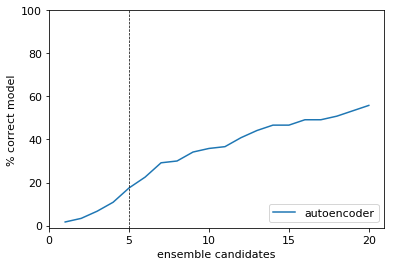

In [23]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
plt.plot(x, correct_model[0][0:max_entries]*100/n_datasets, label='autoencoder')
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks([0,20,40,60,80,100], fontsize=fontsize)
plt.ylabel('% correct model', fontsize=fontsize)
plt.show()